# Model Inversion & Stealing

In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image
import torchvision
import os

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

In [2]:
seed = 42
seed = int(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

Change the dataset and split layer values as desired. Dataset can be one of `mnist`, `f_mnist`, or `cifar` while the split depth is between 1 and 6 for MNIST datasets, and 1 and 8 for the CIFAR dataset.

In [3]:
dataset = 'cifar'
split_layer = 1
data_root = '/root/autodl-tmp'
if dataset == 'mnist':
    trainset = datasets.MNIST(data_root+'/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST(data_root+'/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST(data_root+'/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST(data_root+'/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10(data_root+'/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10(data_root+'/cifar', download=True, train=False, transform=transforms.ToTensor())
    #client, server, clone = CifarNet(), CifarNet(), CifarNet()
    client, server, clone = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10), ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10), ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10)

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


The next part trains the client and server models. You can skip this step and launch the attack directly as well.

In [4]:
client = client.to('cuda:0')
server = server.to('cuda:0')
clone = clone.to('cuda:0')

client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 1
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.to('cuda:0')
        labels = labels.to('cuda:0')
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)
        #print(pred)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 1.3645179271697998 Acc: 38.63134657836645


We are now ready to launch the attack. The next code cell loads `COUNT` many examples from each class of the dataset. Those examples will be used as targets in the attack.

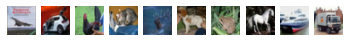

In [5]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()
if dataset == 'cifar':
    display_cifar(inversion_targets)
else:
    display_imagelist(inversion_targets, 28, 28)

We now launch the attack, iterating over the examples from the previous cell.

You can change the `main_iters`, `input_iters`, and `model_iters` variables to observe how the attack performs under different configurations.

epoch:0 finished!
epoch:0 finished!
epoch:0 finished!
epoch:0 finished!
epoch:0 finished!
epoch:0 finished!
epoch:0 finished!
epoch:0 finished!
epoch:0 finished!
epoch:0 finished!


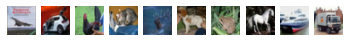

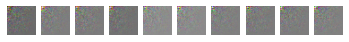

In [6]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    target = target.to('cuda:0')
    #client_out = client(target, end=split_layer)
    client = client.eval()
    client_out = client(target)
    client = client.train()

    # perform the attack
    #result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)
    result = unsplit.model_inversion_white(clone, client_out, target.size() ,main_iters=100, input_iters=10)
  
    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

In [7]:
import pytorch_msssim
from pytorch_msssim import ssim
#print(results[0])

sum = 0
for i in range(10):
    target = inversion_targets[i].unsqueeze(0)
    #print(target)
    ssim_value = ssim(target.to('cpu'), results[i].to('cpu'), data_range=1.0, size_average=True, nonnegative_ssim=True)
    print(ssim_value)
    sum = sum + ssim_value

average_ssim = sum/10
print(f'ssim:{average_ssim}')

tensor(0.0742)
tensor(0.0297)
tensor(0.1019)
tensor(0.0810)
tensor(0.2037)
tensor(0.0788)
tensor(0.1109)
tensor(0.0251)
tensor(0.0504)
tensor(0.0355)
ssim:0.0791274681687355


In [14]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') 
loss_fn_vgg = lpips.LPIPS(net='vgg')
sum1 = 0
sum2 = 0
for i in range(10):
    target = inversion_targets[i].unsqueeze(0)
    lpips_alex = loss_fn_alex(target.to('cpu'), results[i].to('cpu'))
    lpips_vgg = loss_fn_vgg(target.to('cpu'), results[i].to('cpu'))
    print(lpips_alex)
    print(lpips_vgg)
    sum1 = sum1 + lpips_alex
    sum2 = sum2 + lpips_vgg

average_lpips_alex = sum1/10
average_lpips_vgg = sum2/10
print(f'lpips_alex:{average_lpips_alex}')
print(f'lpips_vgg:{average_lpips_vgg}')   

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
tensor([[[[0.2195]]]], grad_fn=<AddBackward0>)
tensor([[[[0.5985]]]], grad_fn=<AddBackward0>)
tensor([[[[0.2734]]]], grad_fn=<AddBackward0>)
tensor([[[[0.6054]]]], grad_fn=<AddBackward0>)
tensor([[[[0.2826]]]], grad_fn=<AddBackward0>)
tensor([[[[0.7363]]]], grad_fn=<AddBackward0>)
tensor([[[[0.2283]]]], grad_fn=<AddBackward0>)
tensor([[[[0.6243]]]], grad_fn=<AddBackward0>)
tensor([[[[0.1301]]]], grad_fn=<AddBackward0>)
tensor([[[[0.4861]]]], grad_fn=<AddBackward0>)
tensor([[[[0.3345]]]], grad_fn=<AddBackward0>)
tensor([[[[0.6193]]]], grad_fn=<AddBackward0>)
tensor([[[[0.2793]]]], grad_fn=<AddBackward0>)
tensor([[[[0.6411]]]], grad_fn=<AddBackward0>)
tensor([[[[0.4

In [26]:
import skimage
from skimage.metrics import peak_signal_noise_ratio

sum = 0
for i in range(10):
    target = inversion_targets[i].unsqueeze(0)
    #print(target)
    psnr_value = ssim(target.to('cpu'), results[i].to('cpu'), data_range=1.0)
    print(psnr_value)
    sum = sum + psnr_value

average_psnr = sum/10
print(f'PSNR:{average_psnr}')
    

tensor(0.4221)
tensor(0.2504)
tensor(0.1968)
tensor(0.2123)
tensor(0.2568)
tensor(0.2949)
tensor(0.2890)
tensor(0.2663)
tensor(0.2468)
tensor(0.3746)
PSNR:0.28099697828292847


In [15]:
from PIL import Image
for i in range(10):
    image = inversion_targets[i].to('cpu').detach().permute(1,2,0)*255
    image = image.numpy().astype(np.uint8)
    reconstruct = results[i].to('cpu').squeeze(0).detach().permute(1,2,0)*255
    reconstruct = reconstruct.numpy().astype(np.uint8)
    #print(image)
    #print(image.shape)
    image = Image.fromarray(image)
    reconstruct = Image.fromarray(reconstruct)
    image.save(f'image{i}.jpg')
    reconstruct.save(f'reconstruct{i}.jpg')